<a href="https://colab.research.google.com/github/PavithraArjunan/DualFeatureNet-Combining-Traditional-and-Deep-Features/blob/main/DS_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Data Augmentation and Preprocessing (OpenCV)

In [ ]:
# Resize all images to 224x224 pixels
import cv2
import os
from tqdm import tqdm

Image_path = r"/content/drive/MyDrive/Project/DS_task/xray_images"

for count, filename in enumerate(tqdm(os.listdir(Image_path)), start=1):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(Image_path, filename)

        # Read image
        img = cv2.imread(file_path)
        if img is None:
            print(f"Warning: Failed to load image {filename}")
            continue

        # Resize image
        resized_img = cv2.resize(img, (224, 224))

        # Create new filename
        new_name = f"car_26-07-25_P{count}.jpg"
        new_path = os.path.join(Image_path, new_name)

        # Save resized image
        cv2.imwrite(new_path, resized_img)

        # Optionally remove original image
        if file_path != new_path:
            os.remove(file_path)



100%|██████████| 3724/3724 [05:20<00:00, 11.61it/s]


Apply Gaussian noise to simulate real-world noise.
Implement advanced augmentations like rotation, perspective transformation, and histogram equalization.

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random

Image_path = r"/content/drive/MyDrive/Project/DS_task/xray_images"

# Folder names for each type
folders = {
    "original": "original",
    "flipped": "flipped",
    "noisy": "noisy",
    "bright": "bright",
    "rotated": "rotated",
    "perspective": "perspective",
    "equalized": "equalized"
}

# Create folders if not exist
for folder in folders.values():
    folder_path = os.path.join(Image_path, folder)
    os.makedirs(folder_path, exist_ok=True)

# Augmentation functions
def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_img = image.astype(np.float32) + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

def adjust_brightness(image, factor=1.2):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 2] *= factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, rot_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

def perspective_transform(image):
    h, w = image.shape[:2]
    margin = 10
    pts1 = np.float32([[margin, margin], [w-margin, margin], [margin, h-margin], [w-margin, h-margin]])
    pts2 = np.float32([
        [margin + random.randint(-5, 5), margin + random.randint(-5, 5)],
        [w - margin + random.randint(-5, 5), margin + random.randint(-5, 5)],
        [margin + random.randint(-5, 5), h - margin + random.randint(-5, 5)],
        [w - margin + random.randint(-5, 5), h - margin + random.randint(-5, 5)],
    ])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)

def histogram_equalization(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        return cv2.equalizeHist(image)

# Main processing loop
for count, filename in enumerate(tqdm(os.listdir(Image_path)), start=1):
    file_path = os.path.join(Image_path, filename)

    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img = cv2.imread(file_path)
    if img is None:
        print(f"Warning: Failed to load image {filename}")
        continue

    img = cv2.resize(img, (224, 224))
    base_name = f"car_26-07-25_P{count}.jpg"

    # Save each augmentation in its folder
    cv2.imwrite(os.path.join(Image_path, folders["original"], base_name), img)
    cv2.imwrite(os.path.join(Image_path, folders["flipped"], base_name), cv2.flip(img, 1))
    cv2.imwrite(os.path.join(Image_path, folders["noisy"], base_name), add_gaussian_noise(img))
    cv2.imwrite(os.path.join(Image_path, folders["bright"], base_name), adjust_brightness(img, factor=1.5))
    cv2.imwrite(os.path.join(Image_path, folders["rotated"], base_name), rotate_image(img, angle=15))
    cv2.imwrite(os.path.join(Image_path, folders["perspective"], base_name), perspective_transform(img))
    cv2.imwrite(os.path.join(Image_path, folders["equalized"], base_name), histogram_equalization(img))

    # Delete original after processing
    os.remove(file_path)


Split the data into training, validation, and test sets

In [ ]:
import os
import shutil
import random

# Paths
base_path = r"/content/drive/MyDrive/Project/DS_task/xray_images"
output_path = r"/content/drive/MyDrive/Project/DS_task/split_dataset"
folders = ["original", "flipped", "noisy", "bright", "rotated", "perspective", "equalized"]

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create target folders
for split in ['train', 'val', 'test']:
    for folder in folders:
        os.makedirs(os.path.join(output_path, split, folder), exist_ok=True)

# Process each augmentation type separately
for folder in folders:
    src_folder = os.path.join(base_path, folder)
    images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    # Copy files to each destination
    for file_list, split in zip([train_files, val_files, test_files], ['train', 'val', 'test']):
        for file_name in file_list:
            src = os.path.join(src_folder, file_name)
            dst = os.path.join(output_path, split, folder, file_name)
            shutil.copy2(src, dst)


## Step 2: Feature Extraction Using OpenCV
Extract features from the images using advanced OpenCV techniques:
Use ORB or SIFT to identify keypoints and descriptors.
Save the descriptors for visualization and analysis.

In [ ]:
!pip install opencv-python opencv-contrib-python


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Choose one extractor
use_sift = True  # set False to use ORB

# Input folder (use your split dataset or any one like 'original')
input_folder = r"/content/drive/MyDrive/Project/DS_task/split_dataset/train/original"

# Output folder for descriptors
output_folder = r"/content/drive/MyDrive/Project/DS_task/features/original"
os.makedirs(output_folder, exist_ok=True)

# Initialize the feature extractor
if use_sift:
    extractor = cv2.SIFT_create()
    feature_type = "SIFT"
else:
    extractor = cv2.ORB_create()
    feature_type = "ORB"

print(f"🔍 Using {feature_type} extractor...")

# Loop over images
for filename in tqdm(os.listdir(input_folder)):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(input_folder, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"⚠️ Failed to load: {filename}")
        continue

    # Extract keypoints and descriptors
    keypoints, descriptors = extractor.detectAndCompute(img, None)

    # Save descriptors as .npy file
    if descriptors is not None:
        npy_name = filename.rsplit('.', 1)[0] + f"_{feature_type}.npy"
        np.save(os.path.join(output_folder, npy_name), descriptors)


🔍 Using SIFT extractor...


100%|██████████| 2606/2606 [32:09<00:00,  1.35it/s]


In [ ]:
### to view the  npy file
 import os
import numpy as np

folder = "/content/drive/MyDrive/Project/DS_task/features/original"

for filename in os.listdir(folder):
    if filename.endswith(".npy"):
        path = os.path.join(folder, filename)
        descriptors = np.load(path)
        print(f"{filename} → shape: {descriptors.shape}")


##  Step 3: Deep Learning Pipelinee


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

# Replace 224 with 128 for faster testing (optional)
img_size = (224, 224)
batch_size = 32

# Load datasets first
raw_train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Project/DS_task/split_dataset/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# ✅ Get class names BEFORE caching/prefetching
num_classes = len(raw_train_data.class_names)

# Now cache and prefetch for performance
train_data = raw_train_data.cache().prefetch(tf.data.AUTOTUNE)

val_data = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Project/DS_task/split_dataset/val",
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
).cache().prefetch(tf.data.AUTOTUNE)


test_data = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Project/DS_task/split_dataset/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
).cache().prefetch(tf.data.AUTOTUNE)



Found 18242 files belonging to 7 classes.
Found 3906 files belonging to 7 classes.
Found 3920 files belonging to 7 classes.


In [ ]:
# Use MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers for transfer learning

# ✅ Use class count from raw_train_data
num_classes = len(raw_train_data.class_names)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
save_path = '/content/drive/MyDrive/Project/DS_task/best_model.h5'

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint(
#     '/content/drive/MyDrive/Project/DS_task/model_epoch_{epoch:02d}.h5',  # Save a new file each epoch
#     save_best_only=False,   # ✅ Always save
#     verbose=1,
#     save_freq='epoch'
# )


# for i in range(10):
#     print(f"Epoch {i+1}/10")
#     model.fit(
#         train_data,
#         epochs=1,
#         validation_data=val_data,
#         callbacks=[checkpoint]
#     )


Epoch 1/10
 92/571 ━━━━━━━━━━━━━━━━━━━━ 14:02 2s/step - accuracy: 0.2688 - loss: 2.0048

KeyboardInterrupt: 

In [ ]:
# Just for demo: save after N batches
batch_count = 0
for x, y in train_data:
    batch_count += 1
    model.train_on_batch(x, y)

    if batch_count % 10 == 0:  # Save every 10 batches
        model.save('/content/drive/MyDrive/Project/DS_task/manual_batch_model.h5')
        print(f"✅ Saved model at batch {batch_count}")

    if batch_count >= 100:  # Optional limit
        break
subset_train = train_data.take(50)  # Takes only 50 batches
model.fit(subset_train, epochs=1, validation_data=val_data, callbacks=[checkpoint])


✅ Saved model at batch 10


✅ Saved model at batch 20


✅ Saved model at batch 30


✅ Saved model at batch 40


✅ Saved model at batch 50


✅ Saved model at batch 60


✅ Saved model at batch 70


✅ Saved model at batch 80


✅ Saved model at batch 90


✅ Saved model at batch 100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5574 - loss: 1.1528
Epoch 1: saving model to /content/drive/MyDrive/Project/DS_task/model_epoch_01.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1355s 28s/step - accuracy: 0.5574 - loss: 1.1524 - val_accuracy: 0.6526 - val_loss: 1.0064


## Step 4: Integrate OpenCV Features with Deep Learning

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Folder path
train_path = "/content/drive/MyDrive/Project/DS_task/split_dataset/train"
img_size = (224, 224)
max_orb_size = 512  # ORB feature length

# Save path
save_dir = "/content"
img_save = os.path.join(save_dir, "X_img.npy")
orb_save = os.path.join(save_dir, "X_orb.npy")
label_save = os.path.join(save_dir, "y.npy")

# ORB extractor
def extract_orb_descriptors(image_path):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(gray, None)
    if des is not None:
        des_flat = des.flatten()
        return des_flat[:max_orb_size] if des_flat.shape[0] >= max_orb_size else np.pad(des_flat, (0, max_orb_size - des_flat.shape[0]))
    else:
        return np.zeros(max_orb_size)

# Load saved progress if exists
X_img = list(np.load(img_save, allow_pickle=True)) if os.path.exists(img_save) else []
X_orb = list(np.load(orb_save, allow_pickle=True)) if os.path.exists(orb_save) else []
y = list(np.load(label_save, allow_pickle=True)) if os.path.exists(label_save) else []

processed_count = len(X_img)
print(f"🔁 Resuming from image {processed_count}")

# Start data loading
class_folders = sorted(os.listdir(train_path))
total_processed = 0

for label in tqdm(class_folders):
    label_folder = os.path.join(train_path, label)
    image_files = os.listdir(label_folder)

    for file in image_files:
        if total_processed < processed_count:
            total_processed += 1
            continue  # Skip already processed

        file_path = os.path.join(label_folder, file)

        # CNN image input
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        X_img.append(img.astype('float32') / 255.0)

        # ORB input
        orb_vec = extract_orb_descriptors(file_path)
        X_orb.append(orb_vec)

        # Label
        y.append(label)

        total_processed += 1

        # Save every 100 images
        if total_processed % 100 == 0:
            print(f"💾 Saving checkpoint at {total_processed} images...")
            np.save(img_save, np.array(X_img))
            np.save(orb_save, np.array(X_orb))
            np.save(label_save, np.array(y))

# Final save
np.save(img_save, np.array(X_img))
np.save(orb_save, np.array(X_orb))
np.save(label_save, np.array(y))
print("✅ Final save completed.")

# Convert and encode
X_img = np.array(X_img)
X_orb = np.array(X_orb)
y = np.array(y)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)


🔁 Resuming from image 0


  0%|          | 0/7 [00:00<?, ?it/s]

💾 Saving checkpoint at 100 images...
💾 Saving checkpoint at 200 images...
💾 Saving checkpoint at 300 images...
💾 Saving checkpoint at 400 images...
💾 Saving checkpoint at 500 images...
💾 Saving checkpoint at 600 images...
💾 Saving checkpoint at 700 images...
💾 Saving checkpoint at 800 images...
💾 Saving checkpoint at 900 images...
💾 Saving checkpoint at 1000 images...
💾 Saving checkpoint at 1100 images...
💾 Saving checkpoint at 1200 images...
💾 Saving checkpoint at 1300 images...
💾 Saving checkpoint at 1400 images...
💾 Saving checkpoint at 1500 images...
💾 Saving checkpoint at 1600 images...
💾 Saving checkpoint at 1700 images...
💾 Saving checkpoint at 1800 images...
💾 Saving checkpoint at 1900 images...
💾 Saving checkpoint at 2000 images...
💾 Saving checkpoint at 2100 images...
💾 Saving checkpoint at 2200 images...
💾 Saving checkpoint at 2300 images...
💾 Saving checkpoint at 2400 images...
💾 Saving checkpoint at 2500 images...
💾 Saving checkpoint at 2600 images...


 14%|█▍        | 1/7 [04:19<25:58, 259.70s/it]

💾 Saving checkpoint at 2700 images...
💾 Saving checkpoint at 2800 images...
💾 Saving checkpoint at 2900 images...
💾 Saving checkpoint at 3000 images...
💾 Saving checkpoint at 3100 images...
💾 Saving checkpoint at 3200 images...
💾 Saving checkpoint at 3300 images...
💾 Saving checkpoint at 3400 images...
💾 Saving checkpoint at 3500 images...
💾 Saving checkpoint at 3600 images...
💾 Saving checkpoint at 3700 images...
💾 Saving checkpoint at 3800 images...
💾 Saving checkpoint at 3900 images...
💾 Saving checkpoint at 4000 images...
💾 Saving checkpoint at 4100 images...
💾 Saving checkpoint at 4200 images...
💾 Saving checkpoint at 4300 images...
💾 Saving checkpoint at 4400 images...
💾 Saving checkpoint at 4500 images...
💾 Saving checkpoint at 4600 images...
💾 Saving checkpoint at 4700 images...
💾 Saving checkpoint at 4800 images...
💾 Saving checkpoint at 4900 images...
💾 Saving checkpoint at 5000 images...
💾 Saving checkpoint at 5100 images...
💾 Saving checkpoint at 5200 images...


 29%|██▊       | 2/7 [22:21<1:01:55, 743.13s/it]

💾 Saving checkpoint at 5300 images...
💾 Saving checkpoint at 5400 images...
💾 Saving checkpoint at 5500 images...
💾 Saving checkpoint at 5600 images...
💾 Saving checkpoint at 5700 images...
💾 Saving checkpoint at 5800 images...
💾 Saving checkpoint at 5900 images...
💾 Saving checkpoint at 6000 images...
💾 Saving checkpoint at 6100 images...
💾 Saving checkpoint at 6200 images...
💾 Saving checkpoint at 6300 images...
💾 Saving checkpoint at 6400 images...
💾 Saving checkpoint at 6500 images...
💾 Saving checkpoint at 6600 images...
💾 Saving checkpoint at 6700 images...
💾 Saving checkpoint at 6800 images...
💾 Saving checkpoint at 6900 images...
💾 Saving checkpoint at 7000 images...
💾 Saving checkpoint at 7100 images...
💾 Saving checkpoint at 7200 images...
💾 Saving checkpoint at 7300 images...
💾 Saving checkpoint at 7400 images...
💾 Saving checkpoint at 7500 images...
💾 Saving checkpoint at 7600 images...
💾 Saving checkpoint at 7700 images...
💾 Saving checkpoint at 7800 images...


 43%|████▎     | 3/7 [1:50:14<3:07:25, 2811.48s/it]

💾 Saving checkpoint at 7900 images...
💾 Saving checkpoint at 8000 images...
💾 Saving checkpoint at 8100 images...
💾 Saving checkpoint at 8200 images...
💾 Saving checkpoint at 8300 images...
💾 Saving checkpoint at 8400 images...
💾 Saving checkpoint at 8500 images...
💾 Saving checkpoint at 8600 images...


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Project/DS_task/manual_batch_model.h5')


In [ ]:
model.fit(
    {"image_input": X_img, "orb_input": X_orb},
    y_encoded,
    epochs=5,  # or however many more epochs you want
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        ModelCheckpoint(
            filepath='/content/drive/MyDrive/Project/DS_task/manual_batch_model.h5',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        )
    ]
)


## Step 5: Evaluation
Evaluate the model's performance on the test set using accuracy, precision, recall, and F1-score.
Visualize model performance using confusion matrices and ROC curves.

100%|██████████| 7/7 [01:37<00:00, 13.98s/it]


123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      bright       0.28      0.04      0.07       560
   equalized       0.00      0.00      0.00       560
     flipped       0.00      0.00      0.00       560
       noisy       0.74      0.31      0.43       560
    original       0.00      0.00      0.00       560
 perspective       0.14      0.03      0.04       560
     rotated       0.16      0.97      0.27       560

    accuracy                           0.19      3920
   macro avg       0.19      0.19      0.12      3920
weighted avg       0.19      0.19      0.12      3920

✅ Accuracy:  0.1921
✅ Precision: 0.1878
✅ Recall:    0.1921
✅ F1 Score:  0.1168


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


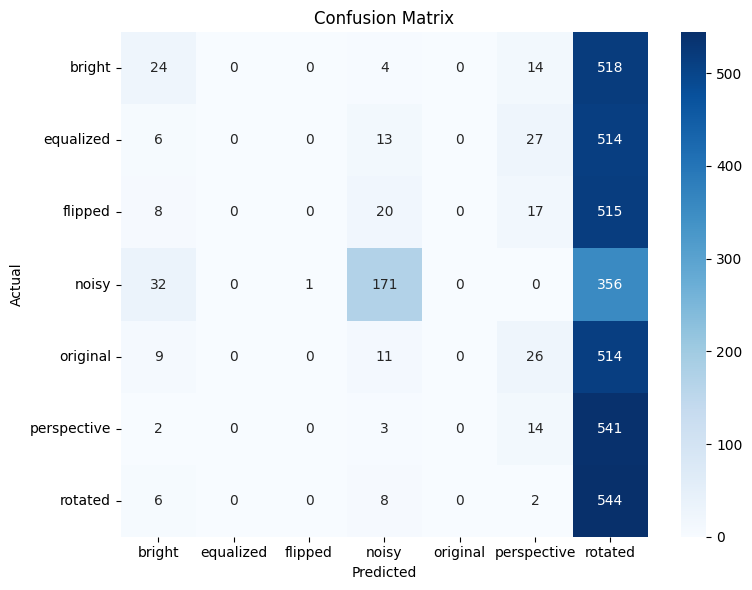

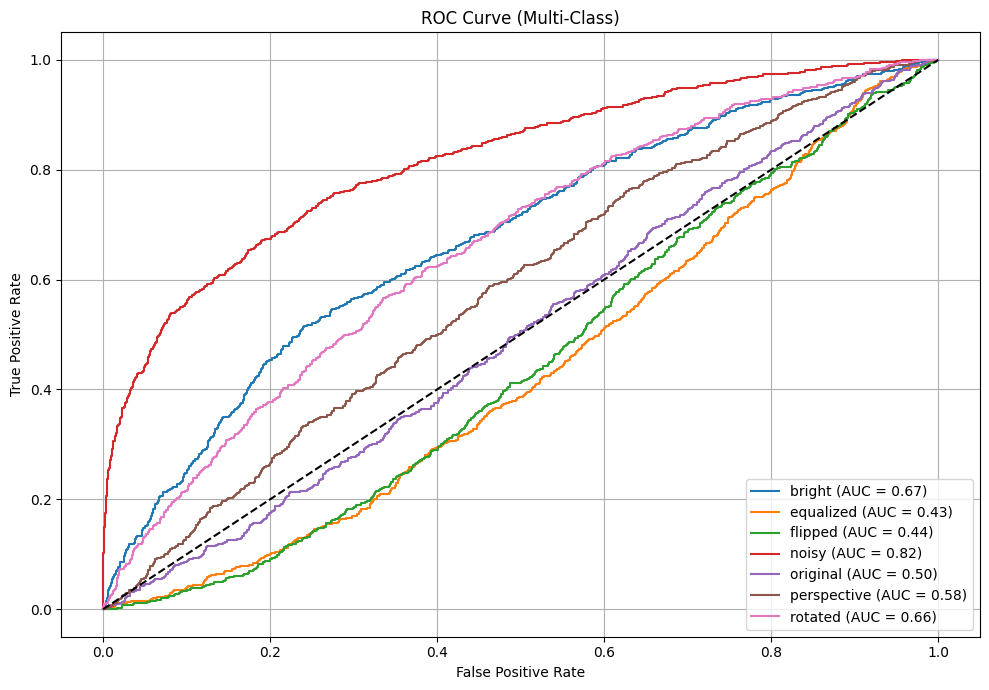

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Paths
test_path = "/content/drive/MyDrive/Project/DS_task/split_dataset/test"
model_path = "/content/drive/MyDrive/Project/DS_task/manual_batch_model.h5"

# Image/ORB setup
img_size = (224, 224)
max_orb_size = 512

def extract_orb_descriptors(image_path):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(gray, None)
    if des is not None:
        des_flat = des.flatten()
        return des_flat[:max_orb_size] if des_flat.shape[0] >= max_orb_size else np.pad(des_flat, (0, max_orb_size - des_flat.shape[0]))
    else:
        return np.zeros(max_orb_size)

# Load test images and features
X_test_img, X_test_orb, y_test = [], [], []

class_folders = sorted(os.listdir(test_path))
for label in tqdm(class_folders):
    label_folder = os.path.join(test_path, label)
    for file in os.listdir(label_folder):
        file_path = os.path.join(label_folder, file)

        img = cv2.imread(file_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        X_test_img.append(img.astype('float32') / 255.0)
        X_test_orb.append(extract_orb_descriptors(file_path))
        y_test.append(label)

# Convert
X_test_img = np.array(X_test_img)
X_test_orb = np.array(X_test_orb)
y_test = np.array(y_test)

# Save for reuse
np.save("X_test_img.npy", X_test_img)
np.save("X_test_orb.npy", X_test_orb)
np.save("y_test.npy", y_test)

# Label encoding
encoder = LabelEncoder()
y_true = encoder.fit_transform(y_test)
class_names = encoder.classes_

# Load model
model = load_model(model_path)

# Predict
if len(model.inputs) == 1:
    y_pred_probs = model.predict(X_test_img)
else:
    y_pred_probs = model.predict([X_test_img, X_test_orb])

y_pred = np.argmax(y_pred_probs, axis=1)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
